In [1]:
import argparse
import attr
import importlib
import json
import logging
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import ml_collections as mlc
from ml_collections import ConfigDict
import numpy as np
import os
import random
import scipy
import seaborn as sns
import sklearn
from sklearn import metrics
from sklearn.utils import shuffle
import subprocess
import sys
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
import time
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.nn import DataParallel
from tensorboardX import SummaryWriter
import easydict
from easydict import EasyDict as edict
import pandas as pd

# Matplotlib specific imports
from matplotlib.cm import get_cmap
from matplotlib import gridspec, cm

# Custom project imports (assuming they are placed correctly in the project path)
project_path = '/home/pmen/Shortcuts-Problem-in-Medical-Image-Analysis/shortcuts-chest-xray-main/shortcuts-chest-xray-main/'
config_path = '/home/pmen/Shortcuts-Problem-in-Medical-Image-Analysis/shortcuts-chest-xray-main/shortcuts-chest-xray-main/config/config.json'
sys.path.append(project_path)
from data.tfdataset import ImageDataset
from model.classifier import Classifier
from model.utils import get_optimizer
from utils.misc import lr_schedule

# Environment configuration
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Seed setting for reproducibility
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
import tensorflow as tf
import numpy as np
import math


2024-03-12 14:28:25.547036: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ohpc/pub/mpi/openmpi3-gnu8/3.1.4/lib:/opt/ohpc/pub/compiler/gcc/8.3.0/lib64
2024-03-12 14:28:25.547079: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def preprocess_image(image_path, img_height=512, img_width=512):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [img_height, img_width])
    img = img / 255.0  # Normalize to [0,1]
    return img

def preprocess(images, pneumothorax_labels, support_devices_labels):
    # Reshape labels to be 2-dimensional
    pneumothorax_labels = tf.reshape(pneumothorax_labels, (-1, 1))
    support_devices_labels = tf.reshape(support_devices_labels, (-1, 1))
    return images, pneumothorax_labels, support_devices_labels


def load_data(csv_file, base_path):
    df = pd.read_csv(csv_file)
    image_paths = df['Path'].apply(lambda x: f"{base_path}/{x}").values
    pneumothorax_labels = df['Pneumothorax'].values.astype(float)
    support_devices_labels = df['Support Devices'].values.astype(float)
    
    image_ds = tf.data.Dataset.from_tensor_slices(image_paths).map(preprocess_image)
    pneumothorax_label_ds = tf.data.Dataset.from_tensor_slices(pneumothorax_labels)
    support_devices_label_ds = tf.data.Dataset.from_tensor_slices(support_devices_labels)
    
    return tf.data.Dataset.zip((image_ds, pneumothorax_label_ds, support_devices_label_ds))


In [11]:
config_path = '/home/pmen/Shortcuts-Problem-in-Medical-Image-Analysis/shortcuts-chest-xray-main/shortcuts-chest-xray-main/config/config.json'

# Assuming you have loaded your config as a dictionary named cfg
with open(config_path, 'r') as f:
    cfg = json.load(f)

# Convert the dictionary to a ConfigDict which allows attribute-like access
cfg = ConfigDict(cfg)

In [12]:
# Assuming `cfg` is your configuration dictionary loaded from the JSON file
dataset = load_data(cfg['train_csv'], cfg['base_path'])
# Apply preprocessing to each element in the dataset
dataset = dataset.map(preprocess)


In [13]:
dataset = dataset.batch(cfg['train_batch_size'])#, drop_remainder=True) 

NOTE: using repeat because I am running out of data

In [14]:
#@markdown Model parameters 
cfg = mlc.ConfigDict()
# Example dimensions for a 512x512 RGB image
n_pixels = 512
n_channels = 3

cfg.model = mlc.ConfigDict()
cfg.model.width = 10  #@param architecture width
cfg.model.depth = 3  #@param model depth
cfg.model.use_bias = True  # whether we add biases to activations.
cfg.model.activation = 'relu'
cfg.model.x_dim = (n_pixels, n_pixels, n_channels)
cfg.model.branch_dim = 2  # architecture width within each branch
cfg.model.regularizer = None  # replace with e.g. 'l2' for weight decay

# output head
cfg.model.output_activation = 'sigmoid'
cfg.model.output_dim = 1

# attribute head
cfg.model.attr_activation = 'sigmoid'
cfg.model.attr_grad_updates = float(-0.05)
cfg.model.attr_dim = 1
# this is a tradeoff between the loss on A and the loss on target Y.
# If it's zero, we ignore the attribute loss completely.
cfg.attr_loss_weight = float(1.0)

cfg.opt = mlc.ConfigDict()
cfg.opt.name = 'adam'
cfg.opt.learning_rate = 0.001
cfg.opt.momentum = 0.9

# Models

## Baseline model - SingleHead class
We build simple MLP models that predict one binary label. This model can be used to assess the performance of the baseline model f(X) -> Y.

## Attribute encoding - SingleHead with frozen feature extractor
In addition, this model can take as an extra input a frozen feature extractor. It then adds a linear layer to this feature extractor to perform the binary classification. Only the weights of this layer are tuned during training. This architecture is used to assess the level of attribute encoding of another model.

## Multi-task - MultiHead with Gradient Reversal
The architecture of the multi-task model first comprises a series of layers that represent a "feature extractor". On top of the feature extractor, we add two heads: 
- one head for the label, which is predicted from a single linear layer,
- one head for an auxiliary task (here the prediction of the color of the square). This head includes at least a non-linear layer to allow a gradient scaling operation.

The weight of the auxiliary loss in the total loss is a hyper-parameter in the method (weight of label loss is fixed to 1.0). A gradient reversal head is added to the auxiliary task. Gradient scaling can then be performed (positive or negative, extra hyper-parameter). Setting both hyper-parameters to 0 corresponds to the baseline single head model.


A config (`cfg`) dictionary specifies the parameters of the MLP architecture.

In [21]:
#@title Model utils


K = tf.keras.backend

class GradientReversal(tf.keras.layers.Layer):
    @tf.custom_gradient
    def grad_reverse(self, x):
        y = tf.identity(x)
        def custom_grad(dy):
          return self.hp_lambda * dy
        return y, custom_grad

    def __init__(self, hp_lambda, **kwargs):
        super(GradientReversal, self).__init__(**kwargs)
        self.hp_lambda = K.variable(hp_lambda, dtype='float', name='hp_lambda')

    def call(self, x, mask=None):
        return self.grad_reverse(x)

    def set_hp_lambda(self,hp_lambda):
        K.set_value(self.hp_lambda, hp_lambda)
    
    def increment_hp_lambda_by(self,increment):
        new_value = float(K.get_value(self.hp_lambda)) +  increment
        K.set_value(self.hp_lambda, new_value)

    def get_hp_lambda(self):
        return float(K.get_value(self.hp_lambda))


class BaselineArch():
  """Superclass for multihead training."""

  def __init__(self, main="y", aux=None, dtype=tf.float32, pos=None):
    """Initializer.

    Args:
      main: name of variable for the main task
      aux: nema of the variable for the auxiliary task
      dtype: desired dtype (e.g. tf.float32).
      pos: ConfigDict that specifies the index of x, y, c, w, u in data tuple.
        Default: data is of the form (x, y, c, w, u).
    """
    self.model = None
    self.inputs = "x"
    self.main = main
    self.aux = aux
    self.dtype = dtype
    if pos is None:
      pos = mlc.ConfigDict()
      pos.x, pos.y, pos.a = 0, 1, 2
    self.pos = pos

  def get_input(self, *batch):
    """Fetch model input from the batch."""
    # first input
    stack = tf.cast(batch[self.pos[self.inputs[0]]], self.dtype)
    # fetch remaining ones
    for c in self.inputs[1:]:
      stack = tf.concat([stack, tf.cast(batch[self.pos[c]], self.dtype)],
                        axis=1)
    return stack

  def get_output(self, *batch):
    """Fetch outputs from the batch."""
    if self.aux:
      return (tf.cast(batch[self.pos[self.main]],self.dtype),
              tf.cast(batch[self.pos[self.aux]], self.dtype))
    else:
      return (tf.cast(batch[self.pos[self.main]],self.dtype))

  def split_batch(self, *batch):
    """Split batch into input and output."""
    return self.get_input(*batch), self.get_output(*batch)

  def fit(self, data: tf.data.Dataset, **kwargs):
    """Fit model on data."""
    ds = data.map(self.split_batch)
    self.model.fit(ds, **kwargs)

  def predict(self, model_input, **kwargs):
    """Predict target Y given the model input. See also: predict_mult()."""
    y_pred = self.model.predict(model_input, **kwargs)
    return y_pred

  def predict_mult(self, data: tf.data.Dataset, num_batches: int, **kwargs):
    """Predict from the TF dataset directly. See also: predict()."""
    pos = self.pos
    y_true_list = []
    y_pred_list = []
    a_true_list = []
    a_pred_list = []

    for batch in data.take(num_batches):
      model_input, (y_true, a_true) = self.split_batch(*batch)
      y_pred, a_pred = self.predict(model_input, **kwargs)
              
      # Convert Tensors to NumPy and store in lists
      y_true_list.append(y_true.numpy())
      a_true_list.append(a_true.numpy())
      y_pred_list.append(y_pred.numpy())
      a_pred_list.append(a_pred.numpy())

    # Concatenate lists of arrays
    y_true_all = np.concatenate(y_true_list, axis=0)
    a_true_all = np.concatenate(a_true_list, axis=0)
    y_pred_all = np.concatenate(y_pred_list, axis=0)
    a_pred_all = np.concatenate(a_pred_list, axis=0)

    return (y_true_all, a_true_all), (y_pred_all, a_pred_all)

  def score(self, data: tf.data.Dataset, num_batches: int, 
            metric: tf.keras.metrics.Metric , **kwargs):
    """Evaluate model on data.

    Args:
      data: TF dataset.
      num_batches: number of batches fetched from the dataset.
      metric: which metric to evaluate (schrouf not be instantiated).
      **kwargs: arguments passed to predict() method.

    Returns:
      score: evaluation score.
    """
    y_true, y_pred = self.predict_mult(data, num_batches, **kwargs)
    return metric()(y_true, y_pred).numpy()


class MultiHead(BaselineArch):
  """Multihead training."""

  def __init__(self, cfg, main, aux, dtype=tf.float32, pos=None): 
    """Initializer.

    Args:
      cfg: A config that describes the MLP architecture.
      main: variable for the main task
      aux: variable for the auxialiary task
      dtype: desired dtype (e.g. tf.float32) for casting data.
    """
    super(MultiHead, self).__init__(main, aux, dtype, pos)
    self.main = "y"
    self.aux = "a"
    self.cfg = cfg
    # build architecture
    self.model, self.feat_extract = self.build()

  def build(self):
    """Build model."""
    cfg = self.cfg
    input_shape = cfg.model.x_dim

    # set config params to defaults if missing
    use_bias = cfg.model.get("use_bias", True)
    activation = cfg.model.get("activation", "relu")
    output_activation = cfg.model.get("output_activation", "sigmoid")

    model_input = tf.keras.Input(shape=input_shape)
    flatten_input = tf.keras.layers.Flatten()(model_input)
    if cfg.model.depth:
      x = tf.keras.layers.Dense(cfg.model.width, use_bias=use_bias,
                                activation=activation,
                                kernel_regularizer=cfg.model.regularizer)(flatten_input)
      for _ in range(cfg.model.depth - 1):
        x = tf.keras.layers.Dense(cfg.model.width, use_bias=use_bias,
                                  activation=activation,
                                  kernel_regularizer=cfg.model.regularizer)(x)
    else:
      x = flatten_input
    feature_extractor = tf.keras.models.Model(inputs=flatten_input,
                                              outputs=x)
    # output layer - a single linear layer
    y = tf.keras.layers.Dense(cfg.model.output_dim,
                              use_bias=cfg.model.use_bias,
                              name="output",
                              activation=output_activation,
                              kernel_regularizer=cfg.model.regularizer)(x)
    # attribute layer - an extra dense layer is required for gradients to flow back
    attr_activation = cfg.model.get("attr_activation", "sigmoid")
    input_branch_a = GradientReversal(hp_lambda=cfg.model.attr_grad_updates)(x)
    a_branch = tf.keras.layers.Dense(cfg.model.branch_dim,
                    use_bias=cfg.model.use_bias,
                    name="attr_branch",
                    activation=activation,
                    kernel_regularizer=cfg.model.regularizer)(input_branch_a)
    a = tf.keras.layers.Dense(cfg.model.attr_dim,
                        use_bias=cfg.model.use_bias,
                        name="attribute",
                        activation=attr_activation,
                        kernel_regularizer=cfg.model.regularizer)(a_branch)
    


    # choose optimizer
    if cfg.opt.name == "sgd":
      opt = tf.keras.optimizers.SGD(learning_rate=cfg.opt.learning_rate,
                                    momentum=cfg.opt.get("momentum", 0.9))
    elif cfg.opt.name == "adam":
      opt = tf.keras.optimizers.Adam(learning_rate=cfg.opt.learning_rate)
    else:
      raise ValueError("Unrecognized optimizer type."
                       "Please select either 'sgd' or 'adam'.")

    # define losses
    losses = {
        "output": cfg.model.get("output_loss", "binary_crossentropy"),
        "attribute": cfg.model.get("attribute_loss", "binary_crossentropy")
    }
    loss_weights = {"output": 1.0,
                    "attribute": cfg.get("attr_loss_weight", 1.0)}
    metrics = {"output": tf.keras.metrics.AUC(),
               "attribute": tf.keras.metrics.AUC()}

    # build model
    model = tf.keras.models.Model(inputs=model_input, outputs=[y,a])
    model.build(input_shape)
    # model.compile(optimizer=opt, loss=tf.keras.losses.BinaryCrossentropy(),
    #               metrics=tf.keras.metrics.BinaryAccuracy())
    model.compile(optimizer=opt, loss=losses, loss_weights=loss_weights,
                  metrics=metrics)
    return model, feature_extractor

  def predict_mult(self, data: tf.data.Dataset, num_batches: int, **kwargs):
    """Predict from the TF dataset directly. See also: predict()."""
    # infer dimensions
    pos = self.pos
    batch = next(iter(data))
    y_dim = batch[pos.y].shape[1]
    a_dim = batch[pos.a].shape[1]

    # begin
    data_iter = iter(data)
    a_true_all = np.array([]).reshape((0, a_dim))
    a_pred_all = np.array([]).reshape((0, a_dim))
    y_true_all = np.array([]).reshape((0, y_dim))
    y_pred_all = np.array([]).reshape((0, y_dim))

    for _ in range(num_batches):
      batch = next(data_iter)
      x, y_true, a_true = batch[pos.x], batch[pos.y], batch[pos.a]
      a_true = tf.reshape(a_true, [-1, a_true.shape[-2]])
      y_true = tf.reshape(y_true, [-1, y_true.shape[-2]])
      y_pred, a_pred = self.predict(x, **kwargs)
      a_true_all = np.append(a_true_all, a_true, axis=0)
      a_pred_all = np.append(a_pred_all, a_pred, axis=0)
      y_true_all = np.append(y_true_all, y_true, axis=0)
      y_pred_all = np.append(y_pred_all, y_pred, axis=0)

    return (y_true_all, a_true_all), (y_pred_all, a_pred_all)

  def score(self, data: tf.data.Dataset, num_batches: int, 
            metric: tf.keras.metrics.Metric, **kwargs):
    """Evaluate model on data.

    Args:
      data: TF dataset.
      num_batches: number of batches fetched from the dataset.
      metric: which metric to evaluate (should not be instantiated).
      **kwargs: arguments passed to predict() method.

    Returns:
      score: evaluation score.
    """
    out_true, out_pred = self.predict_mult(data, num_batches, **kwargs)
    scores = []
    for head in range(len(out_true)):
      score = metric()(out_true[head], out_pred[head])
      scores.append(score.numpy())
    return scores


# Can be used as a single task model fully trained or from a pre-trained
# feature extractor

class SingleHead(BaselineArch):
  """Singlehead training."""

  def __init__(self, cfg, main, dtype=tf.float32, pos=None, feat_extract=None): 
    """Initializer.

    Args:
      cfg: A config that describes the MLP architecture.
      main: variable for the main task
      aux: variable for the auxialiary task
      dtype: desired dtype (e.g. tf.float32) for casting data.
    """
    super(SingleHead, self).__init__(main, None, dtype, pos)
    self.main = "a"
    self.cfg = cfg
    # build architecture
    self.model = self.build(feat_extract)

  def build(self, feat_extract=None):
    """Build model."""
    cfg = self.cfg
    input_shape = cfg.model.x_dim

    # set config params to defaults if missing
    use_bias = cfg.model.get("use_bias", True)
    activation = cfg.model.get("activation", "relu")
    output_activation = cfg.model.get("output_activation", "sigmoid")

    model_input = tf.keras.Input(shape=input_shape)
    flatten_input = tf.keras.layers.Flatten()(model_input)
    if not feat_extract:
      if cfg.model.depth:
        x = tf.keras.layers.Dense(cfg.model.width, use_bias=use_bias,
                                  activation=activation,
                                  kernel_regularizer=cfg.model.regularizer)(flatten_input)
        for _ in range(cfg.model.depth - 1):
          x = tf.keras.layers.Dense(cfg.model.width, use_bias=use_bias,
                                    activation=activation,
                                    kernel_regularizer=cfg.model.regularizer)(x)
      else:
        x = flatten_input
      feature_extractor = x
    else:
      feat_extract.trainable = False
      feature_extractor = feat_extract(flatten_input, training=False)
  
    # output layer
    y = tf.keras.layers.Dense(cfg.model.output_dim,
                              use_bias=cfg.model.use_bias,
                              name="output",
                              activation=output_activation,
                              kernel_regularizer=cfg.model.regularizer)(feature_extractor)  

    # choose optimizer
    if cfg.opt.name == "sgd":
      opt = tf.keras.optimizers.SGD(learning_rate=cfg.opt.learning_rate,
                                    momentum=cfg.opt.get("momentum", 0.9))
    elif cfg.opt.name == "adam":
      opt = tf.keras.optimizers.Adam(learning_rate=cfg.opt.learning_rate)
    else:
      raise ValueError("Unrecognized optimizer type."
                       "Please select either 'sgd' or 'adam'.")

    # build model
    model = tf.keras.models.Model(inputs=model_input, outputs=y)
    model.build(input_shape)
    model.compile(optimizer=opt,
                  loss=cfg.model.get("output_loss", "binary_crossentropy"),
                  metrics=tf.keras.metrics.AUC())

    return model

In [19]:
#@title Model utils

class GradientReversal(tf.keras.layers.Layer):

    @tf.custom_gradient
    def grad_reverse(self, x):
        y = tf.identity(x)
        def custom_grad(dy):
          return self.hp_lambda * dy
        return y, custom_grad

    def __init__(self, hp_lambda, **kwargs):
        super(GradientReversal, self).__init__(**kwargs)
        self.hp_lambda = K.variable(hp_lambda, dtype='float', name='hp_lambda')

    def call(self, x, mask=None):
        return self.grad_reverse(x)

    def set_hp_lambda(self,hp_lambda):
        K.set_value(self.hp_lambda, hp_lambda)
    
    def increment_hp_lambda_by(self,increment):
        new_value = float(K.get_value(self.hp_lambda)) +  increment
        K.set_value(self.hp_lambda, new_value)

    def get_hp_lambda(self):
        return float(K.get_value(self.hp_lambda))


class BaselineArch():
  """Superclass for multihead training."""

  def __init__(self, main="y", aux=None, dtype=tf.float32, pos=None):
    """Initializer.

    Args:
      main: name of variable for the main task
      aux: nema of the variable for the auxiliary task
      dtype: desired dtype (e.g. tf.float32).
      pos: ConfigDict that specifies the index of x, y, c, w, u in data tuple.
        Default: data is of the form (x, y, c, w, u).
    """
    self.model = None
    self.inputs = "x"
    self.main = main
    self.aux = aux
    self.dtype = dtype
    if pos is None:
      pos = mlc.ConfigDict()
      pos.x, pos.y, pos.a = 0, 1, 2
    self.pos = pos

  def get_input(self, *batch):
    """Fetch model input from the batch."""
    # first input
    stack = tf.cast(batch[self.pos[self.inputs[0]]], self.dtype)
    # fetch remaining ones
    for c in self.inputs[1:]:
      stack = tf.concat([stack, tf.cast(batch[self.pos[c]], self.dtype)],
                        axis=1)
    return stack

  def get_output(self, *batch):
    """Fetch outputs from the batch."""
    if self.aux:
      return (tf.cast(batch[self.pos[self.main]],self.dtype),
              tf.cast(batch[self.pos[self.aux]], self.dtype))
    else:
      return (tf.cast(batch[self.pos[self.main]],self.dtype))

  def split_batch(self, *batch):
    """Split batch into input and output."""
    return self.get_input(*batch), self.get_output(*batch)

  def fit(self, data: tf.data.Dataset, **kwargs):
    """Fit model on data."""
    ds = data.map(self.split_batch)
    self.model.fit(ds, **kwargs)

  def predict(self, model_input, **kwargs):
    """Predict target Y given the model input. See also: predict_mult()."""
    y_pred = self.model.predict(model_input, **kwargs)
    return y_pred

  def predict_mult(self, data: tf.data.Dataset, num_batches: int, **kwargs):
    """Predict target Y from the TF dataset directly. See also: predict()."""
    y_true = []
    y_pred = []
    ds_iter = iter(data)
    for _ in range(num_batches):
      batch = next(ds_iter)
      model_input, y = self.split_batch(*batch)
      y_true.extend(y)
      y_pred.extend(self.predict(model_input, **kwargs))
    return np.array(y_true), np.array(y_pred)

  def score(self, data: tf.data.Dataset, num_batches: int, 
            metric: tf.keras.metrics.Metric , **kwargs):
    """Evaluate model on data.

    Args:
      data: TF dataset.
      num_batches: number of batches fetched from the dataset.
      metric: which metric to evaluate (schrouf not be instantiated).
      **kwargs: arguments passed to predict() method.

    Returns:
      score: evaluation score.
    """
    y_true, y_pred = self.predict_mult(data, num_batches, **kwargs)
    return metric()(y_true, y_pred).numpy()


class MultiHead(BaselineArch):
  """Multihead training."""

  def __init__(self, cfg, main, aux, dtype=tf.float32, pos=None): 
    """Initializer.

    Args:
      cfg: A config that describes the MLP architecture.
      main: variable for the main task
      aux: variable for the auxialiary task
      dtype: desired dtype (e.g. tf.float32) for casting data.
    """
    super(MultiHead, self).__init__(main, aux, dtype, pos)
    self.main = "y"
    self.aux = "a"
    self.cfg = cfg
    # build architecture
    self.model, self.feat_extract = self.build()

  def build(self):
    """Build model."""
    cfg = self.cfg
    input_shape = cfg.model.x_dim

    # set config params to defaults if missing
    use_bias = cfg.model.get("use_bias", True)
    activation = cfg.model.get("activation", "relu")
    output_activation = cfg.model.get("output_activation", "sigmoid")

    model_input = tf.keras.Input(shape=input_shape)
    flatten_input = tf.keras.layers.Flatten()(model_input)
    if cfg.model.depth:
      x = tf.keras.layers.Dense(cfg.model.width, use_bias=use_bias,
                                activation=activation,
                                kernel_regularizer=cfg.model.regularizer)(flatten_input)
      for _ in range(cfg.model.depth - 1):
        x = tf.keras.layers.Dense(cfg.model.width, use_bias=use_bias,
                                  activation=activation,
                                  kernel_regularizer=cfg.model.regularizer)(x)
    else:
      x = flatten_input
    feature_extractor = tf.keras.models.Model(inputs=flatten_input,
                                              outputs=x)
    # output layer - a single linear layer
    y = tf.keras.layers.Dense(cfg.model.output_dim,
                              use_bias=cfg.model.use_bias,
                              name="output",
                              activation=output_activation,
                              kernel_regularizer=cfg.model.regularizer)(x)
    # attribute layer - an extra dense layer is required for gradients to flow back
    attr_activation = cfg.model.get("attr_activation", "sigmoid")
    input_branch_a = GradientReversal(hp_lambda=cfg.model.attr_grad_updates)(x)
    a_branch = tf.keras.layers.Dense(cfg.model.branch_dim,
                    use_bias=cfg.model.use_bias,
                    name="attr_branch",
                    activation=activation,
                    kernel_regularizer=cfg.model.regularizer)(input_branch_a)
    a = tf.keras.layers.Dense(cfg.model.attr_dim,
                        use_bias=cfg.model.use_bias,
                        name="attribute",
                        activation=attr_activation,
                        kernel_regularizer=cfg.model.regularizer)(a_branch)
    


    # choose optimizer
    if cfg.opt.name == "sgd":
      opt = tf.keras.optimizers.SGD(learning_rate=cfg.opt.learning_rate,
                                    momentum=cfg.opt.get("momentum", 0.9))
    elif cfg.opt.name == "adam":
      opt = tf.keras.optimizers.Adam(learning_rate=cfg.opt.learning_rate)
    else:
      raise ValueError("Unrecognized optimizer type."
                       "Please select either 'sgd' or 'adam'.")

    # define losses
    losses = {
        "output": cfg.model.get("output_loss", "binary_crossentropy"),
        "attribute": cfg.model.get("attribute_loss", "binary_crossentropy")
    }
    loss_weights = {"output": 1.0,
                    "attribute": cfg.get("attr_loss_weight", 1.0)}
    metrics = {"output": tf.keras.metrics.AUC(),
               "attribute": tf.keras.metrics.AUC()}

    # build model
    model = tf.keras.models.Model(inputs=model_input, outputs=[y,a])
    model.build(input_shape)
    # model.compile(optimizer=opt, loss=tf.keras.losses.BinaryCrossentropy(),
    #               metrics=tf.keras.metrics.BinaryAccuracy())
    model.compile(optimizer=opt, loss=losses, loss_weights=loss_weights,
                  metrics=metrics)
    return model, feature_extractor

  def predict_mult(self, data: tf.data.Dataset, num_batches: int, **kwargs):
    """Predict from the TF dataset directly. See also: predict()."""
    # infer dimensions
    pos = self.pos
    batch = next(iter(data))
    y_dim = batch[pos.y].shape[1]
    a_dim = batch[pos.a].shape[1]

    # begin
    data_iter = iter(data)
    a_true_all = np.array([]).reshape((0, a_dim))
    a_pred_all = np.array([]).reshape((0, a_dim))
    y_true_all = np.array([]).reshape((0, y_dim))
    y_pred_all = np.array([]).reshape((0, y_dim))

    for _ in range(num_batches):
      batch = next(data_iter)
      x, y_true, a_true = batch[pos.x], batch[pos.y], batch[pos.a]
      y_pred, a_pred = self.predict(x, **kwargs)
      a_true_all = np.append(a_true_all, a_true, axis=0)
      a_pred_all = np.append(a_pred_all, a_pred, axis=0)
      y_true_all = np.append(y_true_all, y_true, axis=0)
      y_pred_all = np.append(y_pred_all, y_pred, axis=0)

    return (y_true_all, a_true_all), (y_pred_all, a_pred_all)

  def score(self, data: tf.data.Dataset, num_batches: int, 
            metric: tf.keras.metrics.Metric, **kwargs):
    """Evaluate model on data.

    Args:
      data: TF dataset.
      num_batches: number of batches fetched from the dataset.
      metric: which metric to evaluate (should not be instantiated).
      **kwargs: arguments passed to predict() method.

    Returns:
      score: evaluation score.
    """
    out_true, out_pred = self.predict_mult(data, num_batches, **kwargs)
    scores = []
    for head in range(len(out_true)):
      score = metric()(out_true[head], out_pred[head])
      scores.append(score.numpy())
    return scores


# Can be used as a single task model fully trained or from a pre-trained
# feature extractor

class SingleHead(BaselineArch):
  """Singlehead training."""

  def __init__(self, cfg, main, dtype=tf.float32, pos=None, feat_extract=None): 
    """Initializer.

    Args:
      cfg: A config that describes the MLP architecture.
      main: variable for the main task
      aux: variable for the auxialiary task
      dtype: desired dtype (e.g. tf.float32) for casting data.
    """
    super(SingleHead, self).__init__(main, None, dtype, pos)
    self.main = "a"
    self.cfg = cfg
    # build architecture
    self.model = self.build(feat_extract)

  def build(self, feat_extract=None):
    """Build model."""
    cfg = self.cfg
    input_shape = cfg.model.x_dim

    # set config params to defaults if missing
    use_bias = cfg.model.get("use_bias", True)
    activation = cfg.model.get("activation", "relu")
    output_activation = cfg.model.get("output_activation", "sigmoid")

    model_input = tf.keras.Input(shape=input_shape)
    flatten_input = tf.keras.layers.Flatten()(model_input)
    if not feat_extract:
      if cfg.model.depth:
        x = tf.keras.layers.Dense(cfg.model.width, use_bias=use_bias,
                                  activation=activation,
                                  kernel_regularizer=cfg.model.regularizer)(flatten_input)
        for _ in range(cfg.model.depth - 1):
          x = tf.keras.layers.Dense(cfg.model.width, use_bias=use_bias,
                                    activation=activation,
                                    kernel_regularizer=cfg.model.regularizer)(x)
      else:
        x = flatten_input
      feature_extractor = x
    else:
      feat_extract.trainable = False
      feature_extractor = feat_extract(flatten_input, training=False)
  
    # output layer
    y = tf.keras.layers.Dense(cfg.model.output_dim,
                              use_bias=cfg.model.use_bias,
                              name="output",
                              activation=output_activation,
                              kernel_regularizer=cfg.model.regularizer)(feature_extractor)  

    # choose optimizer
    if cfg.opt.name == "sgd":
      opt = tf.keras.optimizers.SGD(learning_rate=cfg.opt.learning_rate,
                                    momentum=cfg.opt.get("momentum", 0.9))
    elif cfg.opt.name == "adam":
      opt = tf.keras.optimizers.Adam(learning_rate=cfg.opt.learning_rate)
    else:
      raise ValueError("Unrecognized optimizer type."
                       "Please select either 'sgd' or 'adam'.")

    # build model
    model = tf.keras.models.Model(inputs=model_input, outputs=y)
    model.build(input_shape)
    model.compile(optimizer=opt,
                  loss=cfg.model.get("output_loss", "binary_crossentropy"),
                  metrics=tf.keras.metrics.AUC())

    return model

# Baseline task model

In [22]:
metric = tf.keras.metrics.AUC


baseline = []
seed= 0 
tf.random.set_seed(seed)
np.random.seed(seed)
enc = SingleHead(cfg, main="y", dtype=tf.float32, feat_extract=None)
kwargs = {'epochs': 10, 'steps_per_epoch':21, 'verbose': False}
enc.fit(dataset, **kwargs)
kwargs = {'verbose': False}
num_batches = 21
sc = enc.score(dataset, num_batches, metric, **kwargs)
baseline.append(sc)

print("Baseline model: %1.2f +- %.2f" % (np.mean(baseline),np.std(baseline)))

ValueError: too many values to unpack (expected 2)

NameError: name 'self' is not defined

# Bounds on attribute encoding (i.e. LEB and UEB in paper)

In [79]:
#@title Upper bound
metric = tf.keras.metrics.AUC

upper_bound = []
seed=0
tf.random.set_seed(seed)
np.random.seed(seed)
enc = SingleHead(cfg, main="a", dtype=tf.float32, feat_extract=None)
kwargs = {'epochs': 10, 'steps_per_epoch':21, 'verbose': False}
enc.fit(dataset, **kwargs)
kwargs = {'verbose': False}
num_batches = 10
sc = enc.score(dataset, num_batches, metric, **kwargs)
upper_bound.append(sc)

print("Upper bound: %1.2f +- %.2f" % (np.mean(upper_bound),np.std(upper_bound)))

Upper bound: 0.66 +- 0.00


In [42]:
# Assuming num_batches is defined and matches the total batches available in your dataset
# Assuming your dataset is structured as (images, pneumothorax_labels, support_devices_labels)

num_batches = 21  # Adjust based on your specific batch count if necessary
batch_size = 32  # Your batch size
n_train = 672  # Total number of images in your dataset
a_dim = 1  # Assuming binary classification for either pneumothorax or support devices

lower_bound = []
#for seed in [0, 1, 2, 3, 4]:
seed = 0
tf.random.set_seed(seed)
np.random.seed(seed)
a_true_all = np.array([]).reshape((0, a_dim))
a_pred_all = np.array([]).reshape((0, a_dim))

for batch in dataset.take(num_batches):
    # Unpack the batch according to your dataset structure
    images, pneumothorax_labels, support_devices_labels = batch
    
    # Dynamically determine the actual size of the current batch for pneumothorax_labels
    actual_batch_size = pneumothorax_labels.shape[0]
    
    # Extract the labels and ensure it's reshaped to 2D if necessary
    a_true = pneumothorax_labels.numpy()
    a_true = a_true.reshape(-1, a_true.shape[-2])
    
    # Simulate predictions: Adjust to use actual_batch_size
    a_pred = np.random.choice([0, 1], size=(actual_batch_size, a_dim))
    
    # Append the true labels and predictions to their respective accumulators
    a_true_all = np.append(a_true_all, a_true, axis=0)
    a_pred_all = np.append(a_pred_all, a_pred, axis=0)
# Calculate and store the AUC score for this iteration

sc = tf.keras.metrics.AUC()(a_true_all, a_pred_all).numpy()
lower_bound.append(sc)

# Print the lower bound score
print("Lower bound: %1.2f +- %.2f" % (np.mean(lower_bound), np.std(lower_bound)))


[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]

In [69]:
# Let's look at the shapes of each component in a single element (or batch) of the dataset
for images, pneumothorax_labels, support_devices_labels in dataset.take(1):
    print("Images shape:", images.shape)
    print("Pneumothorax labels shape:", pneumothorax_labels.shape)
    print("Support devices labels shape:", support_devices_labels.shape)
    break  # Only take the first element for inspection


Images shape: (32, 512, 512, 3)
Pneumothorax labels shape: (32, 1, 1)
Support devices labels shape: (32, 1, 1)


# Example of Multi-Task model

In [91]:
#@title Initialize from config
cfg.model.attr_grad_updates = float(0.1) # if both are set to 0, this is a baseline model (i.e. the same as with no extra head)
cfg.attr_loss_weight = float(0.75)
clf = MultiHead(cfg, main="y", aux="a", dtype=tf.float32, pos=None)

In [92]:
#@markdown Explore the architecture
clf.model.summary()

Model: "model_21"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 flatten_15 (Flatten)           (None, 786432)       0           ['input_21[0][0]']               
                                                                                                  
 dense_45 (Dense)               (None, 10)           7864330     ['flatten_15[0][0]']             
                                                                                                  
 dense_46 (Dense)               (None, 10)           110         ['dense_45[0][0]']        

In [93]:
#@title Train the model
kwargs = {'epochs': 10, 'steps_per_epoch':2, 'verbose': True}
clf.fit(dataset, **kwargs)
clf.trainable=False

Epoch 1/10
2/2 [==============================] - 5s 2s/step - loss: 0.8788 - output_loss: 0.3619 - attribute_loss: 0.6892 - output_auc_26: 0.0000e+00 - attribute_auc_27: 0.4744
Epoch 2/10
2/2 [==============================] - 3s 2s/step - loss: 0.5131 - output_loss: 0.0000e+00 - attribute_loss: 0.6841 - output_auc_26: 0.0000e+00 - attribute_auc_27: 0.5390
Epoch 3/10
2/2 [==============================] - 3s 1s/step - loss: 13.2437 - output_loss: 12.7238 - attribute_loss: 0.6931 - output_auc_26: 0.5000 - attribute_auc_27: 0.5000
Epoch 4/10
2/2 [==============================] - 3s 1s/step - loss: 6.1024 - output_loss: 5.3789 - attribute_loss: 0.9646 - output_auc_26: 0.5000 - attribute_auc_27: 0.5195    
Epoch 5/10
2/2 [==============================] - 3s 2s/step - loss: 16.0053 - output_loss: 4.5470 - attribute_loss: 15.2777 - output_auc_26: 0.5000 - attribute_auc_27: 0.4054   
Epoch 6/10
2/2 [==============================] - 4s 2s/step - loss: 14.6865 - output_loss: 12.1014 - attri

In [94]:
#@title Define the decision threshold by maximizing the F1-score on validation data

from sklearn.metrics import precision_recall_curve
def f1_curve(truth, prediction_scores, e=1e-6):
  precision, recall, thresholds = precision_recall_curve(truth, prediction_scores)
  f1 = 2*recall*precision/(recall+precision+e)
  return thresholds, f1[:-1]

def threshold_at_max_f1_score(truth, prediction_scores):
  thresholds, f1 = f1_curve(truth, prediction_scores)
  peak_idx = np.argmax(f1)
  return thresholds[peak_idx]

In [95]:
kwargs = {'verbose': False}
num_batches = 2
metric = tf.keras.metrics.AUC
scores_val = clf.score(dataset, num_batches, metric, **kwargs)
print(scores_val)

[0.0, 0.5]


In [96]:
kwargs = {'verbose': False}
yt, yp = clf.predict_mult(dataset, num_batches, **kwargs)
threshold = threshold_at_max_f1_score(yt[0],yp[0])
threshold

/opt/itu/easybuild/software/Anaconda3/2023.03-1/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


0.0

In [97]:
#@title Fairness metrics

# As per the work of Alabdulmohsin et al., 2021

def fairness_metrics(y_pred, y_true, sens_attr):
  eps = 1e-5
  groups = np.unique(sens_attr).tolist()

  max_error = 0
  min_error = 1

  max_mean_y = 0
  min_mean_y = 1

  max_mean_y0 = 0  # conditioned on y = 0
  min_mean_y0 = 1

  max_mean_y1 = 0
  min_mean_y1 = 1

  for group in groups:
    yt = y_true[sens_attr == group].astype('int32')
    ypt = (y_pred[sens_attr == group]).astype('int32')
    err = -np.mean(yt * np.log(ypt+eps) + (1-yt)*np.log(1-ypt+eps))
    mean_y = np.mean(y_pred[sens_attr == group])
    neg = np.logical_and(sens_attr == group, y_true == 0)
    pos = np.logical_and(sens_attr == group, y_true == 1)
    mean_y0 = np.mean(y_pred[neg])
    mean_y1 = np.mean(y_pred[pos])

    if err > max_error:
      max_error = err
    if err < min_error:
      min_error = err

    if mean_y > max_mean_y:
      max_mean_y = mean_y
    if mean_y < min_mean_y:
      min_mean_y = mean_y

    if mean_y0 > max_mean_y0:
      max_mean_y0 = mean_y0
    if mean_y0 < min_mean_y0:
      min_mean_y0 = mean_y0

    if mean_y1 > max_mean_y1:
      max_mean_y1 = mean_y1
    if mean_y1 < min_mean_y1:
      min_mean_y1 = mean_y1
  
  eo = 0.5*(max_mean_y0 - min_mean_y0 + max_mean_y1 - min_mean_y1)
  dp = max_mean_y - min_mean_y
  err_parity = max_error - min_error

  return eo, dp, err_parity

In [98]:
#@title Evaluate the model on test data
kwargs = {'verbose': False}
num_batches = 20
metric = tf.keras.metrics.AUC
scores = clf.score(dataset, num_batches, metric, **kwargs)
scores

[0.5, 0.5]

In [100]:
yt, yp = clf.predict_mult(dataset, num_batches, **kwargs)
eo, dp, ep = fairness_metrics(yp[0]>=threshold,
                              yt[0],yt[1].astype('int32'))

In [ ]:
#@title Evaluate model on counterfactual test data
kwargs = {'verbose': False}
num_batches = 20
metric = tf.keras.metrics.AUC

scores_flipped = clf.score(test_data_flipped, num_batches,metric, **kwargs)
scores_flipped

[0.70343816, 0.5]

In [ ]:
#@title Evaluate attribute encoding based on a frozen feature extractor from the multi-task model
enc = SingleHead(cfg, main="a", dtype=tf.float32, feat_extract=clf.feat_extract)
kwargs = {'epochs': 30, 'steps_per_epoch':20, 'verbose': False}
enc.fit(train_data, **kwargs)
kwargs = {'verbose': False}
num_batches = 20
metric = tf.keras.metrics.AUC
sc = enc.score(test_data, num_batches, metric, **kwargs)
sc

0.20959115

# Piecing the elements together: ShorT

In [ ]:
#@title ShorT method
def shortcut_testing(cfg, train_data, test_data, counterfact_data, val_data,
                     range_grads, seeds = [0,1,2,3,4], num_epochs_train = 30,
                     num_batch_test = 5):
  """Shortcut testing.

  Requires:
  - cfg: a config dictionary of model specifications
  - train_data: tf dataset of train data respecting the positions for x,y,a
  - test_data: tf dataset of test data
  - counterfact_data: tf dataset of counterfactual test images
  - val_data: validation data to compute decision threshold
  - range_grads: np array of gradient scalings
  - seeds: list of seed numbers to fix, per gradient scaling
  - num_epoch_train: int, number of epochs for training
  - num_batch_test: number of batches to test the model on

  Outputs:
  scores_y: np array of size (# gradient scalings, # seeds) of test performance on Y
  encoding_a: np array of model's attribute encoding
  equ_odds: np array of equalized odds on test data
  dem_par: similar, demographic parity
  err_par: error parity
  count_fair: counterfactual fairness (computed locally then averaged)
  scores_c: global performance on Y on counterfactual data
  models: tf.Keras.model instances
  """ 


  scores_y = np.zeros((len(range_grads), len(seeds)))
  scores_c = np.zeros((len(range_grads), len(seeds)))
  encoding_a = np.zeros((len(range_grads), len(seeds)))
  equ_odds = np.zeros((len(range_grads), len(seeds)))
  dem_par = np.zeros((len(range_grads), len(seeds)))
  err_par = np.zeros((len(range_grads), len(seeds)))
  count_fair = np.zeros((len(range_grads), len(seeds)))
  models = []
  metric = tf.keras.metrics.AUC
  loss_weight = cfg.attr_loss_weight
  for g, grad_scaling in enumerate(range_grads):
    cfg.model.attr_grad_updates = float(grad_scaling)

    if grad_scaling == 0:  ## baseline model with no other head
      cfg.attr_loss_weight = float(0.0)
    else:
      cfg.attr_loss_weight = float(loss_weight)
    
    for s, seed in enumerate(seeds):
      tf.random.set_seed(seed)
      np.random.seed(seed)
      # instantiate
      clf = MultiHead(cfg, main="y", aux="a", dtype=tf.float32, pos=None)
      # train the multi-head model
      kwargs = {'epochs': num_epochs_train, 'steps_per_epoch':20, 'verbose': False}
      clf.fit(train_data, **kwargs)
      clf.trainable = False

      # estimate attribute encoding by freezing the weights of the feature extractor
      enc = SingleHead(cfg, main="a", dtype=tf.float32, feat_extract=clf.feat_extract)
      kwargs = {'epochs': num_epochs_train, 'steps_per_epoch':20, 'verbose': False}
      enc.fit(train_data, **kwargs)
      kwargs = {'verbose': False}
      encoding_a[g,s] = enc.score(test_data, num_batch_test,
                                  metric, **kwargs)

      # Model performance on test
      scores = clf.score(test_data, num_batch_test, metric, **kwargs)
      scores_y[g,s] = scores[0]

      # from validation data, obtain threshold for decision making
      out_true, out_pred = clf.predict_mult(val_data,
                                            num_batches=num_batch_test,
                                            **kwargs)
      threshold = threshold_at_max_f1_score(out_true[0],out_pred[0])

      # Model statistical fairness metric
      out_true, out_pred = clf.predict_mult(test_data, num_batches=num_batch_test, **kwargs)
      eo, dp, ep = fairness_metrics(out_pred[0]>=threshold,
                                    out_true[0],out_true[1].astype('int32'))
      equ_odds[g,s] = eo
      dem_par[g,s] = dp
      err_par[g,s] = ep
      # global shortcutting
      scores = clf.score(counterfact_data, num_batch_test, metric, **kwargs)
      scores_c[g,s] = scores[0]
      # counterfactual fairness metric
      cf_true, cf_pred = clf.predict_mult(counterfact_data, num_batches=num_batch_test,
                                          **kwargs)
      count_fair[g,s] = np.mean(np.abs(
          (out_pred[0]>=threshold).astype(float) - (cf_pred[0]>=threshold).astype(float)))
      models.append(clf)
      del clf
  return scores_y, encoding_a, equ_odds, dem_par, err_par, count_fair, scores_c, models

In [ ]:
#@title Run ShorT

# Ensure that these parameters cover the attribute encoding from LEB to UEB
range_grads = [-0.09, -0.07, -0.05, -0.03, -0.02, -0.01, -0.005,0.0, 0.005, 0.01, 0.02, 0.03, 0.05,0.07, 0.09]

# This should take some time to run
acc_y, acc_a, eo, dp, ep, cf, counter_y, models = shortcut_testing(cfg, train_data,
                                                      test_data, valid_data,
                                                      test_data_flipped,
                                                      range_grads,
                                                      num_epochs_train=100,
                                                      num_batch_test=20)


In [ ]:
#@markdown Derive the correlation

filt = acc_y >= 0.8  #@param User-defined performance threshold. The goal is to discard trivial models
corr, p = scipy.stats.spearmanr(acc_a[filt],cf[filt])
print(corr)
print(p)


-0.3569529841881291
0.002605921051570268


In [ ]:
#@title Plot utils

SMALL_SIZE = 10
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

palette = sns.color_palette('tab20b')

def plot_scale_gradients_encoding(scale_gradients, encoding_a, 
                                  upper_bound, lower_bound):
  """Plots the intervention compared to attribute encoding.

  Inputs:
  scale_gradients: numpy array of scale gradients used
  encoding_a: numpy array of attribute encoding values, as measure by transfer learning
  upper_bound: list or numpy array of maximum attribute encoding
  lower_bound: list or numpy array of minimum attribute encoding
  """
  
  sg_mean = np.mean(encoding_a, axis=1)
  sg_std = np.std(encoding_a, axis=1)

  fig = plt.figure(figsize=(5,4))
  ax = fig.add_axes([0,0,1,1])
  ax.errorbar(scale_gradients, sg_mean, 
                yerr=sg_std, 
                fmt='x', 
                color='tab:blue',
                ecolor='tab:blue')
  plt.hlines(np.mean(upper_bound),np.min(scale_gradients), np.max(scale_gradients),
            colors=[0.4,0.4,0.4],linestyles='dashed')
  plt.hlines(np.mean(lower_bound),np.min(scale_gradients), np.max(scale_gradients),
            colors=[0.4,0.4,0.4],linestyles='dashed')
  ax.set_xlabel('Scale Gradient')
  ax.set_ylabel('Attribute encoding')
  plt.show

def plot_fairness_encoding(encoding_m, fair_m, perf_m, perf_thresh = 0):
  """Plots fairness results vs attribute encoding.
  
  Inputs:
  encoding_m: encoding metric result, as numpy array
  fair_m: fairness metric result, as numpy array
  perf_m: model performance on the output label, as numpy array
  perf_thresh: what minimum performance to consider
  """

  filt = perf_m <= perf_thresh

  fig = plt.figure(figsize=(5,4))
  plt.scatter(encoding_m, fair_m,color=[0.6,0,0.2],alpha=0.5)
  plt.scatter(encoding_m[filt], fair_m[filt],color=[0.2,0.2,0.2])
  plt.xlabel('Attribute Accuracy')
  plt.ylabel('Fairness')
  plt.show()

def point_z_order(c, midpoint):
  deviation = np.zeros_like(c)
  for i in range(c.shape[0]):
    if c[i] > midpoint:
      deviation[i] = (c[i]-midpoint) / (np.max(c)-midpoint)
    else:
      deviation[i] = (midpoint-c[i]) / (midpoint-np.min(c))
  return np.argsort(deviation)

def performance_fairness_age_frontier_plot(encoding_m, fair_m, perf_m,
                                           scale_gradients, cmap='PRGn'):
  
  class MidpointNormalize(mpl.colors.Normalize):
    """
    class to help renormalize the color scale
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

  baseline_models = np.argwhere(np.array(scale_gradients)==0.0)[0]
  if baseline_models.shape[0] == 0:
    baseline_models = int(len(scale_gradients)/2)
  midpoint = encoding_m[baseline_models,:].mean()
  baseline_model_perf = perf_m[baseline_models,:].mean()
  baseline_model_fair = fair_m[baseline_models,:].mean()

  print(f'Baseline model Attribute encoding: {midpoint:.2f}')
  print(f'Baseline model Performance: {baseline_model_perf:.4f}')
  print(f'Baseline model Fairness: {baseline_model_fair:.4f}')

  norm =  MidpointNormalize(midpoint = midpoint)

  attr = encoding_m.flatten()
  z_order = point_z_order(attr, midpoint)

  fair =fair_m.flatten()
  perf = perf_m.flatten()
  fig = plt.figure(figsize=(5,4))
  ax = fig.add_axes([0,0,1,1])
  plt.scatter(fair[z_order], perf[z_order], s=30, c=attr[z_order], cmap=cmap, norm=norm)
  # overplot the baseline models in red
  plt.scatter(fair_m[baseline_models,:], perf_m[baseline_models,:], s=30,
                   color=(0.8, 0.2, 0.2))
  plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),label='Attribute Encoding')
  plt.ylabel('Performance')
  plt.xlabel('Fairness')
  plt.show()

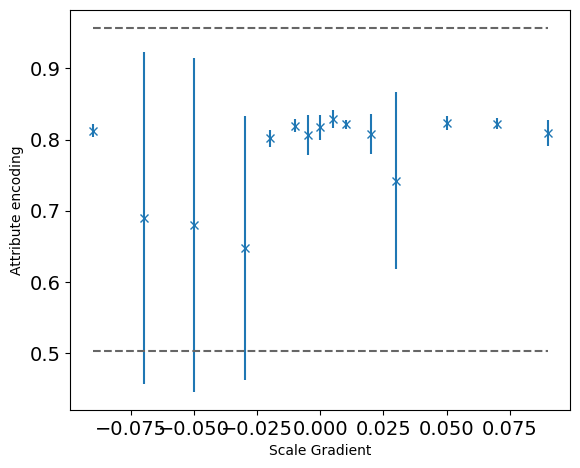

In [ ]:
#@title Plot scale gradient vs age encoding
plot_scale_gradients_encoding(range_grads, acc_a, upper_bound, lower_bound)

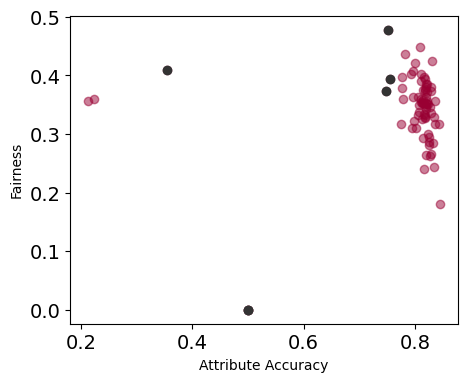

In [ ]:
#@title Plot Fairness w.r.t. attribute encoding
suffix = "{}_EO".format(cfg_data.corr_a_y1)
plot_fairness_encoding(acc_a, cf, acc_y, perf_thresh = 0.8)

Baseline model Attribute encoding: 0.82
Baseline model Performance: 0.8409
Baseline model Fairness: 0.1070


/tmp/ipykernel_35255/1052147022.py:113: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),label='Attribute Encoding')


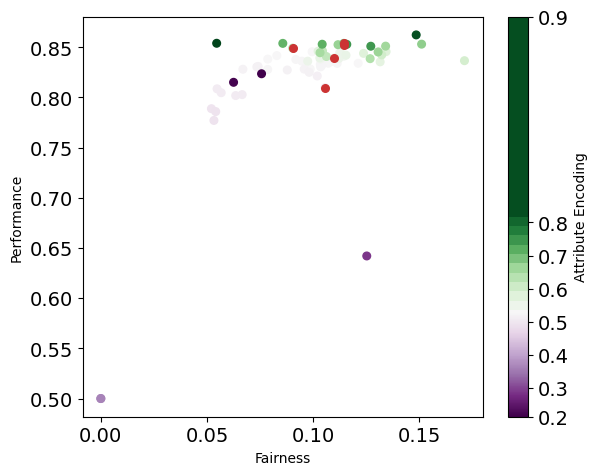

In [ ]:
#@title Pareto plot of fairness-performance colored by attribute encoding
performance_fairness_age_frontier_plot(acc_a,eo,acc_y,range_grads)

In [ ]:
#@title Selecting a model and dropping the attribute head for deployment

fairness_threshold = 0.09 #@param
gradient_parameters = np.array(range_grads).reshape(-1,1).repeat(5,axis=1)

possible_models = acc_y[eo<=fairness_threshold]
possible_gradients = gradient_parameters[eo<=fairness_threshold]
filt = eo<=fairness_threshold

ind = np.argmax(possible_models)
selected_gradient = float(possible_gradients[ind])
selected_model = models[np.argwhere(filt.flatten()).tolist()[ind][0]]
print("Selected gradient parameter: {}".format(selected_gradient))
print("Selected model performance: {}".format(possible_models[ind]))
print("Selected model fairness: {}".format(eo[eo<=fairness_threshold][ind]))

Selected gradient parameter: 0.005
Selected model performance: 0.8540408611297607
Selected model fairness: 0.054577580001308856


In [ ]:
selected_model.model.summary()

Model: "model_134"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_134 (InputLayer)         [(None, 28, 28, 3)]  0           []                               
                                                                                                  
 flatten_92 (Flatten)           (None, 2352)         0           ['input_134[0][0]']              
                                                                                                  
 dense_153 (Dense)              (None, 10)           23530       ['flatten_92[0][0]']             
                                                                                                  
 dense_154 (Dense)              (None, 10)           110         ['dense_153[0][0]']              
                                                                                          

In [ ]:
# Create a new model by selecting all layers except the ones related to the attribute
remove = ['attribute', 'attr_branch', 'gradient']  # corresponds to the names of the layer (partial matches ok), as defined in the MultiHead class

final_model = tf.keras.Sequential()
for layer in clf.model.layers:
  match = [to_pop in layer.name for to_pop in remove]
  if not any(match):
    final_model.add(layer)
    layer.trainable = False


In [ ]:
final_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_10 (Flatten)        (None, 2352)              0         
                                                                 
 dense_30 (Dense)            (None, 10)                23530     
                                                                 
 dense_31 (Dense)            (None, 10)                110       
                                                                 
 dense_32 (Dense)            (None, 10)                110       
                                                                 
 output (Dense)              (None, 1)                 11        
                                                                 
Total params: 23,761
Trainable params: 0
Non-trainable params: 23,761
_________________________________________________________________


In [ ]:
x = test_dataset['train']['image']
y_pred = final_model.predict_on_batch(x)

In [ ]:
sklearn.metrics.roc_auc_score(test_dataset['train']['label'], y_pred)

0.8332877499999999